## ORB: Simulation of Position holding for ROV 

**ORB: An efficient alternative to SIFT or SURF**

 - This algorithm was brought up by Ethan Rublee, Vincent Rabaud, Kurt Konolige and Gary R. Bradski in 2011. 
   - https://docs.opencv.org/3.4/d1/d89/tutorial_py_orb.html

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
# import Displacement.library.trak_utils as tu
import PIL
import numpy as np
import pandas
# import Displacement.library.vid_stabil as vs
import imutils
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

from boxsim.imports import *
import boxsim.core as bs

#### Show the random walk function make_trajectory3

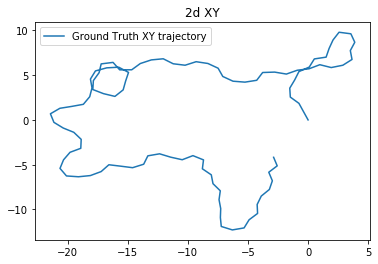

In [6]:
trajectory = bs.make_trajectory3(100, zscale=5)
plt.plot(trajectory[:,0], trajectory[:,1])
plt.legend(['Ground Truth XY trajectory'])
plt.title('2d XY')
plt.show()

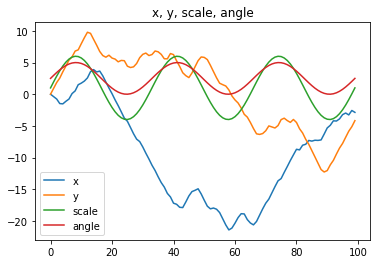

In [7]:
plt.plot(trajectory)
plt.legend(['x', 'y', 'scale', 'angle'])
plt.title('x, y, scale, angle')
plt.show()

In [40]:
# def get_subimage(img, pos):
#     img, cntr0  = sliceImage(img, [400,600], pos)
#     return img

In [41]:
# last_img = np.zeros((400,600,3))
# def track_image_keypnts(img,i):
#     pos0 = get_next(trajectory, i)
#     pos1 = get_next(trajectory, i+1)
#     
#     img0, cntr0 = get_subimage(img, pos0)
#     img1, cntr1 = get_subimage(img, pos1)
#     
#     move_gt = cntr1[0]-cntr0[0], cntr1[1]-cntr0[1], 0
#     
#     move_result, pts = track_features(img0, img1)
#     
#     # print(f'{move_gt[i,:]},  [{move_result[i,1]:2.1f},  {move_result[i,0]:2.1f}], Num keypoints {len(pts)}')
#     pts = np.int0(pts)
#     
#     img_kps = np.copy(img0)
#     for i in pts:
#         x,y = i.ravel()
#         cv2.circle(img_kps,(x,y),3,255,-1)
#     return img_kps, move_gt, move_result, pts

#### We choose a large natural image to get image slices to simulate with
 Yosemite_NP_M  (1880 x 2880 x 3)

(1880, 2880, 3)

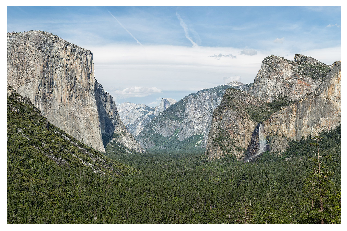

In [8]:
main_img = np.asarray(PIL.Image.open("Yosemite_NP_M.jpg"))

# main_img = cv2.imread('Yosemite_NP_M.jpg',0) 
bs.show_img(main_img)
main_img.shape

#### Test  cv2.goodFeaturesToTrack() on a 400 x 600 slice of the large image
Uses harris corner detector, good for buildings and furnature, does not seem robust to noise on natural images

Number of keypoints 191


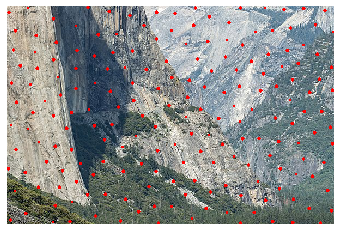

In [10]:
img0 = np.copy(bs.sliceImage(main_img, [400,600], [1100,1000])[0])

cnrs = cv2.goodFeaturesToTrack(cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY),
                                   maxCorners=200,
                                   qualityLevel=0.01,
                                   minDistance=30,
                                   blockSize=3)
print('Number of keypoints', len(cnrs))
for i in cnrs:
    x,y = i.ravel()
    cv2.circle(img0,(x,y),3,255,-1)

bs.show_img(img0)


In [32]:
class LoadImages(Pipeline):
    def __init__(self, src, valid_exts=(".jpg", ".png")):
        self.src = src
        self.valid_exts = valid_exts

        super(LoadImages, self).__init__()

    def generator(self):
        source = utils.list_images(self.src, self.valid_exts)
        while self.has_next():
            image_file = next(source)
            image = cv2.imread(image_file)

            data = {
                "image_file": image_file,
                "image": image
            }

            if self.filter(data):
                yield self.map(data)
a

<generator object firstn at 0x7f6ead6790f8>


<generator object firstn at 0x7f6ead6790f8>

In [ ]:
# import moviepy.editor as mvp
# from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
# n_pnts = 50
# trajectory = make_trajectory2(n_pnts,2, scale=5)
# 
# move_result = np.zeros((trajectory.shape[0], 3))
# move_gt = np.zeros((trajectory.shape[0], 3))
# num_kpts = np.zeros(trajectory.shape[0], dtype=np.int0)
# 
# with FFMPEG_VideoWriter('out.mp4', (600,400), 24.0) as video:
#     for i in range(n_pnts-1):
#         img_kps, move_gt[i,:], move_result[i,:], pts = track_image_keypnts(main_img, i)
#         num_kpts[i] = len(pts)
#         cv2.imshow("keypoints", img_kps)
#         cv2.waitKey(10)
#         video.write_frame(img_kps)
#         print(':', end='', flush=True)  
# 
# cv2.destroyAllWindows()


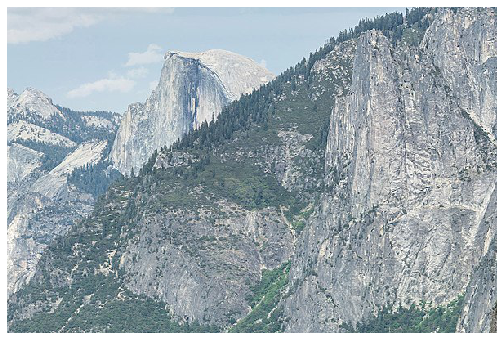

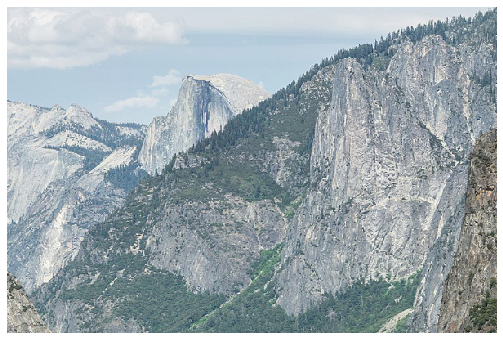

In [16]:
n_pnts = 10
main_img = np.asarray(PIL.Image.open("Yosemite_NP_M.jpg"))
# main_img = cv2.imread('Yosemite_NP_M.jpg',0) 
bs.IMAGE_PATCH_SIZE = [400, 600]

startpos = [i//2 for i in main_img.shape[:2]]

trajectory = bs.make_trajectory3(n_pnts, xyscale=5, startpos=startpos)

bs.last_pos = bs.get_next(trajectory, 0)
bs.last_img, bs.last_pos = bs.get_image_patch(main_img, bs.last_pos)

bs.show_img(bs.last_img,figsize=(10,6))

start_img_copy, _  = bs.get_image_patch(main_img, startpos, 
                                        size=[int(i*1.25) for i in bs.IMAGE_PATCH_SIZE], rot=0 )
start_img_copy = cv2.resize(start_img_copy, (600,400))
start_img = np.copy(start_img_copy)
bs.show_img(start_img,figsize=(10,6))


move_calc = np.zeros((trajectory.shape[0], 3))
move_true = np.zeros((trajectory.shape[0], 3))
num_kpts = np.zeros(trajectory.shape[0], dtype=np.int0)

::::::::::
   true_x  true_y    true_a  calc_y  calc_x  calc_a  num_kpts
0     0.0     0.0  2.500000     0.0     0.0     0.0       0.0
1     4.0    -3.0  4.665064     0.0     0.0     0.0       0.0
2     8.0    -5.0  0.334936     0.0     0.0     0.0       0.0
3    13.0    -4.0  2.500000     0.0     0.0     0.0       0.0
4    17.0    -7.0  4.665064     0.0     0.0     0.0       0.0
5    21.0    -5.0  0.334936     0.0     0.0     0.0       0.0
6    21.0     0.0  2.500000     0.0     0.0     0.0       0.0
7    22.0     5.0  4.665064     0.0     0.0     0.0       0.0
8    18.0     8.0  0.334936     0.0     0.0     0.0       0.0
9    13.0     7.0  2.500000     0.0     0.0     0.0       0.0
Start pos  [ 940 1440]


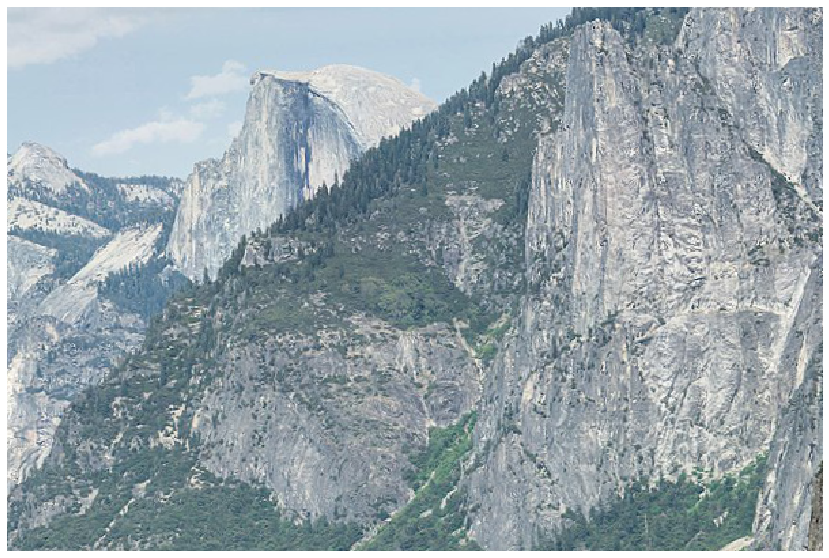

In [20]:
# with FFMPEG_VideoWriter('rov_sim.mp4', (1200, 400), 10.0) as video:
if True:    
    for i in range(n_pnts):
        
        start_img = np.copy(start_img_copy)
        cur_img, move_true[i,:] = bs.next_image(main_img, trajectory, i)

        num_kpts[i] = 0    
        move_calc[i,:] = 0,0,0
        
        # cv2.imshow("keypoints", img_kps)
        cv2.imshow("keypoints", cv2.cvtColor(cur_img, cv2.COLOR_RGB2BGR))
        cv2.waitKey(100)
        print(':', end='', flush=True)  

cv2.destroyAllWindows()         
# tu.show_img(main_img)

move_true[:,:2] = move_true[:,:2] - bs.START_POS

df = pandas.DataFrame(np.column_stack((move_true, move_calc, num_kpts)))
df.columns = ['true_x','true_y', 'true_a','calc_y','calc_x', 'calc_a', 'num_kpts']
print("")
print(df.tail(20))

bs.show_img(cur_img,figsize=(15,10))

print("Start pos ", bs.START_POS)

NameError: name 'matches' is not defined

In [21]:
print(df.head(20))
# tu.show_img(img_kps,figsize=(20,10))



   true_x  true_y    true_a  calc_y  calc_x  calc_a  num_kpts
0     0.0     0.0  2.500000     0.0     0.0     0.0       0.0
1     4.0    -3.0  4.665064     0.0     0.0     0.0       0.0
2     8.0    -5.0  0.334936     0.0     0.0     0.0       0.0
3    13.0    -4.0  2.500000     0.0     0.0     0.0       0.0
4    17.0    -7.0  4.665064     0.0     0.0     0.0       0.0
5    21.0    -5.0  0.334936     0.0     0.0     0.0       0.0
6    21.0     0.0  2.500000     0.0     0.0     0.0       0.0
7    22.0     5.0  4.665064     0.0     0.0     0.0       0.0
8    18.0     8.0  0.334936     0.0     0.0     0.0       0.0
9    13.0     7.0  2.500000     0.0     0.0     0.0       0.0


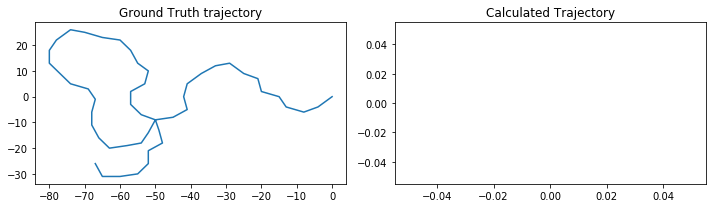

In [24]:
# out.release()
cum_mov_true = np.cumsum(move_true, axis=0) 
cum_mov_calc = np.cumsum(move_calc, axis=0) 

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].plot(cum_mov_true[:,0], cum_mov_true[:,1])
axes[0].set_title('Ground Truth trajectory')
axes[1].plot(cum_mov_calc[:,1], cum_mov_calc[:,0])
axes[1].set_title('Calculated Trajectory')

plt.tight_layout()

In [22]:

from nbdev.export import *
notebook2script()









 




Converted 00_core.ipynb.
Converted 20-test-simulator.ipynb.
Converted 99_index.ipynb.
